# [1] VAE with multiple properties

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.2 MB/s eta 0:00:00


In [14]:
import rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import MolFromSmiles,MolToSmiles
from tqdm import tqdm
import numpy as np

import pandas as pd
import pickle

import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

In [15]:
class MolData(Dataset):
    def __init__(self,smis,props,toks):
        self.smis = smis
        self.props = props
        self.toks = toks + ['<','>'] #'<'; start of sequence, '>'; end of sequence
        self.Ntok = len(toks)
        self.Nmax = 120

    def __len__(self):
        return len(self.smis)

    def __getitem__(self,idx):
        smi = '<'+self.smis[idx]+'>'
        smi += '>'*(self.Nmax-len(smi))

        x_all = np.array([self.toks.index(s) for s in smi]).flatten()
        y = x_all[1:] #output

        x = torch.LongTensor(x_all)
        y = torch.LongTensor(y)
        prop = torch.Tensor(self.props[idx])
        return x,y,prop


In [65]:
class MolVAE(nn.Module):
    def __init__(self,dim_x0,dim_x1,dim_h,n_layer,d_ratio,dim_z,dim_zh,d_ratio2):
        super(MolVAE,self).__init__()
        self.n_layer = n_layer
        self.emb_layer = nn.Embedding(dim_x0,dim_x1)

        self.enc = nn.GRU(dim_x1,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.fc_z1 = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,2*dim_z))

        self.z_to_prop = nn.Sequential(
                        nn.Linear(dim_z,dim_zh),
                        nn.ReLU(),
                        nn.Dropout(p=d_ratio2),
                        nn.Linear(dim_zh,dim_zh),
                        nn.ReLU(),
                        nn.Dropout(p=d_ratio2),
                        nn.Linear(dim_zh,dim_zh),
                        nn.ReLU(),
                        nn.Linear(dim_zh,3))

        self.fc_z2 = nn.Linear(dim_z,dim_h)

        self.dec = nn.GRU(dim_x1+dim_z,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.out = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,dim_x0))

    def forward(self,x):
        x_emb = self.emb_layer(x)

        mu,log_var = self.encoder(x_emb)
        eps = torch.randn_like(mu)
        z = mu + eps*torch.exp(log_var/2)

        out = self.decoder(x_emb[:,:-1],z)
        p_out = self.regressor(z)
        return out,p_out,mu,log_var

    def encoder(self,x):
        _,h1 = self.enc(x,None)
        h2 = self.fc_z1(h1[-1])
        mu,log_var = torch.chunk(h2,2,dim=-1)
        return mu,log_var

    def decoder(self,x,z):
        N,L,F = x.shape
        h0_z = z.unsqueeze(1).repeat(1,L,1)

        x_in = torch.cat([x,h0_z],dim=-1)

        h0_rnn = self.fc_z2(z).unsqueeze(0).repeat(self.n_layer,1,1)
        out,h_d = self.dec(x_in,h0_rnn)
        out = self.out(out)
        return out

    def regressor(self,z):
        prop = self.z_to_prop(z)
        return prop

    def sampling(self,x0,z,h0=None,is_first=True):
        x = self.emb_layer(x0)

        N,L,F = x.shape
        h0_z = z.unsqueeze(1).repeat(1,L,1)
        x_in = torch.cat([x,h0_z],dim=-1)

        if is_first:
            h0 = self.fc_z2(z).unsqueeze(0).repeat(self.n_layer,1,1)

        out,h1 = self.dec(x_in,h0)
        out = self.out(out)
        return out,h1

In [17]:
def Sampling(sampler,dim_z,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
        inits = torch.LongTensor([34]*n_sample)
        loader = DataLoader(inits,batch_size=100)

        Sampled = []
        Zs = []
        Ps = []
        for inp in tqdm(loader):
            x_in = inp.reshape(-1,1)

            x_hat = []
            z = torch.randn(len(x_in),dim_z)
            pp = sampler.regressor(z)
            Ps.append(pp.cpu().detach().numpy().reshape(-1,3))

            h = None
            is_first = True
            for seq_iter in range(max_len):

                if seq_iter > 0:
                    is_first = False

                out,h = sampler.sampling(x_in,z,h,is_first)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)
                #x_in = torch.argmax(prob,-1).view(-1,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)
            Zs.append(z.cpu().detach().numpy())

    Sampled = np.vstack(Sampled)
    Zs = np.vstack(Zs)
    Ps = np.vstack(Ps)

    Mols = []
    Lat1 = []
    P1 = []
    for s,z,p in zip(Sampled,Zs,Ps):
        n_end = np.sum(s==35)

        if n_end == 0:
            continue

        n = np.min(np.where(s==35)[0])
        m = ''.join(tok_lib[s[:n]].tolist())
        Mols.append(m)
        Lat1.append(z)
        P1.append(p)

    Vals = []
    Lat2 = []
    P2 = []
    for smi,z,p in zip(Mols,Lat1,P1):
        mol = MolFromSmiles(smi)
        if not mol is None:
            Vals.append(MolToSmiles(mol))
            Lat2.append(z.reshape(1,-1))
            P2.append(p)

    Uni = list(set(Vals))
    Lat2 = np.vstack(Lat2)
    P2 = np.array(P2)
    return Vals,Lat2,P2,len(Vals),len(Uni)

In [7]:
def LinearAnnealing(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KRICT/UST수업/250k_rndm_zinc_drugs_clean_3.csv')
smi_ = [ss.split()[0] for ss in df['smiles']]
prop_ = []
for k in ['logP', 'qed', 'SAS']:
    prop_.append(np.array(df[k]).reshape(-1,1))
prop_ = np.hstack(prop_)

toks = pickle.load(open('/content/drive/MyDrive/KRICT/UST수업/ZINC_Tokens.pkl','rb'))

iis = np.arange(len(smi_))
np.random.seed(1)
np.random.shuffle(iis)

n_train = 200000
n_val = 25000
n_t = 25000

smi_train = [smi_[i] for i in iis[:n_train]]
smi_val = [smi_[i] for i in iis[n_train:n_train+n_val]]

pp_ = prop_[iis[:n_train]]
mean_prop = np.mean(pp_,0).reshape(1,-1)
std_prop = np.std(pp_,0).reshape(1,-1)
Scaling = torch.Tensor(std_prop).view(1,-1)

prop_ = (prop_ - mean_prop)/std_prop
prop_ = prop_.tolist()

pp_train = [prop_[i] for i in iis[:n_train]]
pp_val = [prop_[i] for i in iis[n_train:n_train+n_val]]

batch_size = 64

train_data = MolData(smi_train,pp_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data = MolData(smi_val,pp_val,toks)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

DimZ = 156
model = MolVAE(36,128,480,3,0.2,DimZ,64,0.15)

lr = 1e-4
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

num_epoch = 100
max_norm = 5

LOGs = []
Betas = LinearAnnealing(n_iter=num_epoch,start=0.0,stop=0.2,n_cycle=2).tolist()
l_reg = 0.4

for ep in range(num_epoch):
    model.train()
    for inp in tqdm(train_loader):
        x_in = inp[0]
        tgt = inp[1].view(-1)
        p_tgt = inp[2]

        x_out,p_out,mu,log_var = model(x_in)

        rec = ce_loss(x_out.reshape(-1,36),tgt)
        kld = torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1))
        reg = torch.mean(torch.abs(p_tgt-p_out))

        loss = rec + Betas[ep]*kld + l_reg*reg

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        Sim = []
        Mus = []
        Stds = []
        KLDs = 0
        REGs = 0
        Ns = 0
        for inp in tqdm(test_loader):
            x_in = inp[0]
            tgt = inp[1].view(-1)
            p_tgt = inp[2]

            x_out,p_out,mu,log_var = model(x_in)

            kld = torch.sum(torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1),-1))
            reg = torch.sum(torch.abs(p_tgt-p_out)*Scaling,0)

            KLDs += kld.cpu().detach().numpy().flatten()[0]
            REGs += reg.cpu().detach().numpy().flatten()
            Ns += len(x_in)

            id_out = np.argmax(x_out.cpu().detach().numpy(),-1)
            id_in = x_in[:,1:].cpu().detach().numpy()
            acc = np.mean(id_out==id_in,1).reshape(-1,1)

            Sim.append(acc)
            Mus.append(mu.cpu().detach().numpy())
            Stds.append(torch.exp(log_var/2).cpu().detach().numpy())

        Sim = np.vstack(Sim)
        Mus = np.vstack(Mus)
        Stds = np.vstack(Stds)
        mols,z_mols,p_mols,val,uniq = Sampling(model,DimZ,10000,120,tok_lib)

        print(ep,Betas[ep],np.min(Sim),np.max(Sim),np.mean(Sim),np.std(Sim),KLDs/Ns,REGs/Ns,val,uniq)
        #LOGs.append([ep,Betas[ep],np.min(Sim),np.max(Sim),np.mean(Sim),np.std(Sim),KLDs/Ns,REGs/Ns,val,uniq])

        #res = {'state_dict':model.state_dict(),'Mus':Mus,'Vars':Stds,'Mols':mols,'Zs':z_mols,'Ps':p_mols,'Val':val,'Unique':uniq}
        #torch.save(res,'molvae_props/Logs_'+str(ep)+'.pth.tar')

In [19]:
df = pd.read_csv('/content/drive/MyDrive/KRICT/UST수업/250k_rndm_zinc_drugs_clean_3.csv')
smi_ = [ss.split()[0] for ss in df['smiles']]
prop_ = []
for k in ['logP', 'qed', 'SAS']:
    prop_.append(np.array(df[k]).reshape(-1,1))
prop_ = np.hstack(prop_)

toks = pickle.load(open('/content/drive/MyDrive/KRICT/UST수업/ZINC_Tokens.pkl','rb'))

iis = np.arange(len(smi_))
np.random.seed(1)
np.random.shuffle(iis)

n_train = 200000
n_val = 25000
n_t = 25000

smi_train = [smi_[i] for i in iis[:n_train]]
smi_val = [smi_[i] for i in iis[n_train:n_train+n_val]]

pp_ = prop_[iis[:n_train]]
mean_prop = np.mean(pp_,0).reshape(1,-1)
std_prop = np.std(pp_,0).reshape(1,-1)
Scaling = torch.Tensor(std_prop).view(1,-1)

prop_ = (prop_ - mean_prop)/std_prop
prop_ = prop_.tolist()

pp_train = [prop_[i] for i in iis[:n_train]]
pp_val = [prop_[i] for i in iis[n_train:n_train+n_val]]

batch_size = 64

train_data = MolData(smi_train,pp_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data = MolData(smi_val,pp_val,toks)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

DimZ = 156
model = MolVAE(36,128,480,3,0.2,DimZ,64,0.15)

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molvae_param.pth.tar",map_location='cpu')
model.load_state_dict(chkpt['state_dict'])

mols,z_mols,p_mols,val,uniq = Sampling(model,DimZ,5000,120,tok_lib)

100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


100%|██████████| 156/156 [00:31<00:00,  4.93it/s]


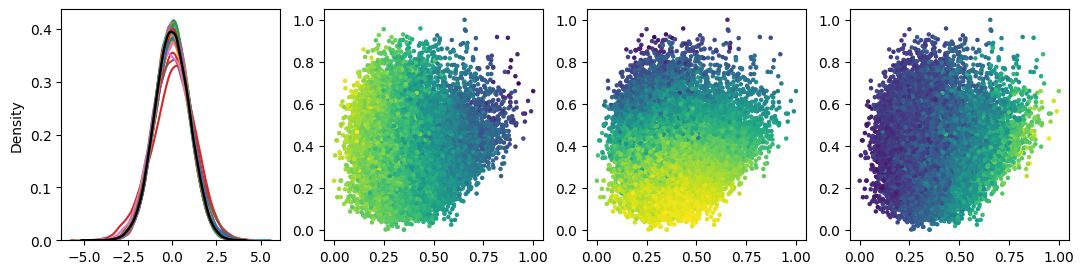

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

mu_val = chkpt['Mus']
std_val = chkpt['Vars']
eps = np.random.randn(len(mu_val),DimZ)
z_val = mu_val + eps*std_val
c_val = np.array(pp_val)

pca = PCA(2)
pcs = pca.fit_transform(z_val)
pcs = MinMaxScaler().fit_transform(pcs)

#Validation 데이터셋에 있는 분자들에 대한 결과
plt.figure(figsize=(13,3))
plt.subplot(1,4,1)
for i in tqdm(range(DimZ)):
    sns.kdeplot(z_val[:,i])
sns.kdeplot(eps[:,0],c='k',lw=1.7)

for i in range(3):
    plt.subplot(1,4,i+2)
    plt.scatter(pcs[:,0],pcs[:,1],marker='o',s=5,c=c_val[:,i])

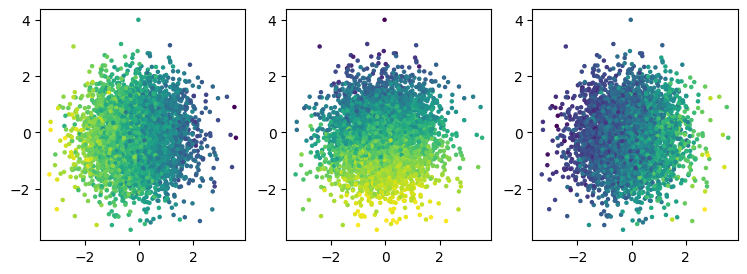

In [30]:
c_samp = mean_prop + p_mols*std_prop
pcs_samp = pca.transform(z_mols)

plt.figure(figsize=(9,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(pcs_samp[:,0],pcs_samp[:,1],marker='o',s=5,c=c_samp[:,i])

# [2] cVAE with multiple properties

In [32]:
class MolData(Dataset):
    def __init__(self,smis,props,toks):
        self.smis = smis
        self.props = props
        self.toks = toks + ['<','>'] #'<'; start of sequence, '>'; end of sequence
        self.Ntok = len(toks)
        self.Nmax = 120

    def __len__(self):
        return len(self.smis)

    def __getitem__(self,idx):
        smi = '<'+self.smis[idx]+'>'
        smi += '>'*(self.Nmax-len(smi))

        x_all = np.array([self.toks.index(s) for s in smi]).flatten()
        y = x_all[1:] #output

        x = torch.LongTensor(x_all)
        y = torch.LongTensor(y)
        prop = torch.Tensor(self.props[idx])
        return x,y,prop

In [66]:
class MolCVAE(nn.Module):
    def __init__(self,dim_x0,dim_x1,dim_h,n_layer,d_ratio,dim_z,dim_zh,d_ratio2):
        super(MolCVAE,self).__init__()
        self.n_layer = n_layer
        self.emb_layer = nn.Embedding(dim_x0,dim_x1)

        self.enc = nn.GRU(dim_x1,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.fc_z1 = nn.Sequential(
                        nn.Linear(dim_h+3,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,2*dim_z))

        self.fc_z2 = nn.Linear(dim_z+3,dim_h)

        self.dec = nn.GRU(dim_x1+dim_z+3,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.out = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,dim_x0))

    def forward(self,x,c):
        x_emb = self.emb_layer(x)

        mu,log_var = self.encoder(x_emb,c)
        eps = torch.randn_like(mu)
        z = mu + eps*torch.exp(log_var/2)

        out = self.decoder(x_emb[:,:-1],z,c)
        return out,mu,log_var

    def encoder(self,x,c):
        _,h1 = self.enc(x,None)
        h1c = torch.cat([h1[-1],c],dim=1)
        h2 = self.fc_z1(h1c)
        mu,log_var = torch.chunk(h2,2,dim=-1)
        return mu,log_var

    def decoder(self,x,z,c):
        N,L,F = x.shape
        z_c = torch.cat([z,c],dim=1)
        h0_z = z_c.unsqueeze(1).repeat(1,L,1)

        x_in = torch.cat([x,h0_z],dim=-1)

        h0_rnn = self.fc_z2(z_c).unsqueeze(0).repeat(self.n_layer,1,1)
        out,h_d = self.dec(x_in,h0_rnn)
        out = self.out(out)
        return out

    def sampling(self,x0,z,c,h0=None,is_first=True):
        x = self.emb_layer(x0)

        N,L,F = x.shape
        z_c = torch.cat([z,c],dim=1)
        h0_z = z_c.unsqueeze(1).repeat(1,L,1)
        x_in = torch.cat([x,h0_z],dim=-1)

        if is_first:
            h0 = self.fc_z2(z_c).unsqueeze(0).repeat(self.n_layer,1,1)

        out,h1 = self.dec(x_in,h0)
        out = self.out(out)
        return out,h1

In [34]:
def Sampling(sampler,dim_z,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
        inits = torch.LongTensor([34]*n_sample)
        loader = DataLoader(inits,batch_size=100)

        Sampled = []
        Zs = []
        Ps = []
        for inp in tqdm(loader):
            x_in = inp.reshape(-1,1)

            x_hat = []
            z = torch.randn(len(x_in),dim_z)
            c = torch.randn(len(x_in),3)

            h = None
            is_first = True
            for seq_iter in range(max_len):

                if seq_iter > 0:
                    is_first = False

                out,h = sampler.sampling(x_in,z,c,h,is_first)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)
                #x_in = torch.argmax(prob,-1).view(-1,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)
            Zs.append(z.cpu().detach().numpy())
            Ps.append(c.cpu().detach().numpy())

    Sampled = np.vstack(Sampled)
    Zs = np.vstack(Zs)
    Ps = np.vstack(Ps)

    Mols = []
    Lat1 = []
    P1 = []
    for s,z,p in zip(Sampled,Zs,Ps):
        n_end = np.sum(s==35)

        if n_end == 0:
            continue

        n = np.min(np.where(s==35)[0])
        m = ''.join(tok_lib[s[:n]].tolist())
        Mols.append(m)
        Lat1.append(z)
        P1.append(p)

    Vals = []
    Lat2 = []
    P2 = []
    for smi,z,p in zip(Mols,Lat1,P1):
        mol = MolFromSmiles(smi)
        if not mol is None:
            Vals.append(MolToSmiles(mol))
            Lat2.append(z.reshape(1,-1))
            P2.append(p)

    Uni = list(set(Vals))
    Lat2 = np.vstack(Lat2)
    P2 = np.array(P2)
    return Vals,Lat2,P2,len(Vals),len(Uni)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KRICT/UST수업/250k_rndm_zinc_drugs_clean_3.csv')
smi_ = [ss.split()[0] for ss in df['smiles']]
prop_ = []
for k in ['logP', 'qed', 'SAS']:
    prop_.append(np.array(df[k]).reshape(-1,1))
prop_ = np.hstack(prop_)

toks = pickle.load(open('/content/drive/MyDrive/KRICT/UST수업/ZINC_Tokens.pkl','rb'))

iis = np.arange(len(smi_))
np.random.seed(1)
np.random.shuffle(iis)

n_train = 200000
n_val = 25000
n_t = 25000

smi_train = [smi_[i] for i in iis[:n_train]]
smi_val = [smi_[i] for i in iis[n_train:n_train+n_val]]

pp_ = prop_[iis[:n_train]]
mean_prop = np.mean(pp_,0).reshape(1,-1)
std_prop = np.std(pp_,0).reshape(1,-1)

Scaling = torch.Tensor(std_prop).view(1,-1)

prop_ = (prop_ - mean_prop)/std_prop
prop_ = prop_.tolist()

pp_train = [prop_[i] for i in iis[:n_train]]
pp_val = [prop_[i] for i in iis[n_train:n_train+n_val]]

batch_size = 64

train_data = MolData(smi_train,pp_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data = MolData(smi_val,pp_val,toks)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

DimZ = 156
#model = MolVAE(36,64,350,2,0.2,DimZ,64,0.15).cuda()
model = MolCVAE(36,128,480,3,0.2,DimZ,64,0.15)

lr = 1e-4
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

num_epoch = 100
max_norm = 5

LOGs = []
Betas = LinearAnnealing(n_iter=num_epoch,start=0.0,stop=0.2,n_cycle=2).tolist()

for ep in range(num_epoch):
    model.train()
    for inp in tqdm(train_loader):
        x_in = inp[0]
        tgt = inp[1]view(-1)
        p_tgt = inp[2]

        x_out,mu,log_var = model(x_in,p_tgt)

        rec = ce_loss(x_out.reshape(-1,36),tgt)
        kld = torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1))

        loss = rec + Betas[ep]*kld

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        Sim = []
        Mus = []
        Stds = []
        KLDs = 0
        REGs = 0
        Ns = 0
        for inp in tqdm(test_loader):
            x_in = inp[0]
            tgt = inp[1].view(-1)
            p_tgt = inp[2]

            x_out,mu,log_var = model(x_in,p_tgt)

            kld = torch.sum(torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1),-1))

            KLDs += kld.cpu().detach().numpy().flatten()[0]
            Ns += len(x_in)

            id_out = np.argmax(x_out.cpu().detach().numpy(),-1)
            id_in = x_in[:,1:].cpu().detach().numpy()
            acc = np.mean(id_out==id_in,1).reshape(-1,1)

            Sim.append(acc)
            Mus.append(mu.cpu().detach().numpy())
            Stds.append(torch.exp(log_var/2).cpu().detach().numpy())

        Sim = np.vstack(Sim)
        Mus = np.vstack(Mus)
        Stds = np.vstack(Stds)
        mols,z_mols,p_mols,val,uniq = Sampling(model,DimZ,10000,120,tok_lib)

        print(ep,Betas[ep],np.min(Sim),np.max(Sim),np.mean(Sim),np.std(Sim),KLDs/Ns,val,uniq)
        LOGs.append([ep,Betas[ep],np.min(Sim),np.max(Sim),np.mean(Sim),np.std(Sim),KLDs/Ns,val,uniq])

In [37]:
df = pd.read_csv('/content/drive/MyDrive/KRICT/UST수업/250k_rndm_zinc_drugs_clean_3.csv')
smi_ = [ss.split()[0] for ss in df['smiles']]
prop_ = []
for k in ['logP', 'qed', 'SAS']:
    prop_.append(np.array(df[k]).reshape(-1,1))
prop_ = np.hstack(prop_)

toks = pickle.load(open('/content/drive/MyDrive/KRICT/UST수업/ZINC_Tokens.pkl','rb'))

iis = np.arange(len(smi_))
np.random.seed(1)
np.random.shuffle(iis)

n_train = 200000
n_val = 25000
n_t = 25000

smi_train = [smi_[i] for i in iis[:n_train]]
smi_val = [smi_[i] for i in iis[n_train:n_train+n_val]]

pp_ = prop_[iis[:n_train]]
mean_prop = np.mean(pp_,0).reshape(1,-1)
std_prop = np.std(pp_,0).reshape(1,-1)
Scaling = torch.Tensor(std_prop).view(1,-1)

prop_ = (prop_ - mean_prop)/std_prop
prop_ = prop_.tolist()

pp_train = [prop_[i] for i in iis[:n_train]]
pp_val = [prop_[i] for i in iis[n_train:n_train+n_val]]

batch_size = 64

train_data = MolData(smi_train,pp_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data = MolData(smi_val,pp_val,toks)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

DimZ = 156
model = MolCVAE(36,128,480,3,0.2,DimZ,64,0.15)

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molcvae_param.pth.tar",map_location='cpu')
model.load_state_dict(chkpt['state_dict'])

mols,z_mols,p_mols,val,uniq = Sampling(model,DimZ,5000,120,tok_lib)

100%|██████████| 50/50 [02:05<00:00,  2.51s/it]


100%|██████████| 156/156 [00:41<00:00,  3.78it/s]


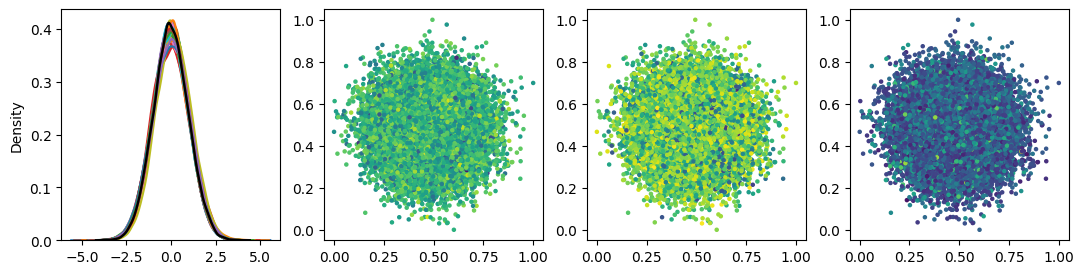

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

mu_val = chkpt['Mus']
std_val = chkpt['Vars']
eps = np.random.randn(len(mu_val),DimZ)
z_val = mu_val + eps*std_val
c_val = mean_prop + std_prop*np.array(pp_val)

pca = PCA(2)
pcs = pca.fit_transform(z_val)
pcs = MinMaxScaler().fit_transform(pcs)

#Validation 데이터셋에 있는 분자들에 대한 결과
plt.figure(figsize=(13,3))
plt.subplot(1,4,1)
for i in tqdm(range(DimZ)):
    sns.kdeplot(z_val[:,i])
sns.kdeplot(eps[:,0],c='k',lw=1.7)

for i in range(3):
    plt.subplot(1,4,i+2)
    plt.scatter(pcs[:,0],pcs[:,1],marker='o',s=5,c=c_val[:,i])

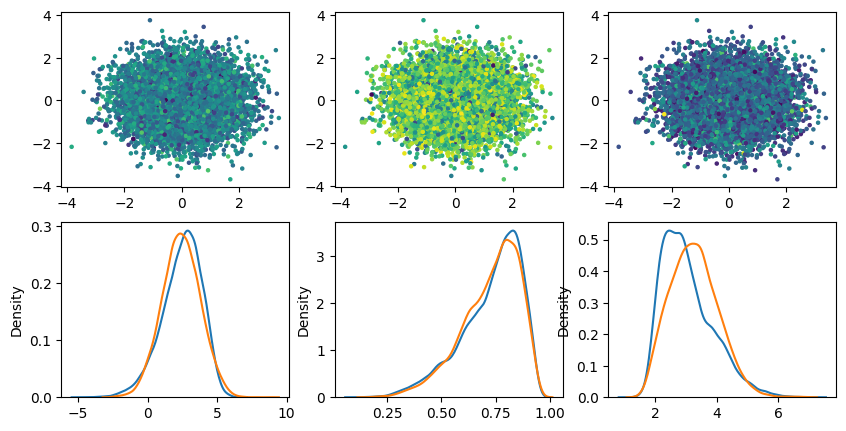

In [77]:
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors
from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def GetProp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return [[-100,-100],False]
    else:
        pvec = [Descriptors.MolLogP(mol),qed(mol),sascorer.calculateScore(mol)]
        return [pvec,True]

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molcvae_param.pth.tar",map_location='cpu')

c_samp = []
for m in tqdm(chkpt['Mols']):
    pv = GetProp(m)
    if pv[1]:
        c_samp.append(pv[0])

c_samp = np.array(c_samp)

pcs_samp = pca.transform(chkpt['Zs'])

plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.scatter(pcs_samp[:,0],pcs_samp[:,1],marker='o',s=5,c=c_samp[:,i])

    plt.subplot(2,3,i+1+3)
    sns.kdeplot(c_val[:,i])
    sns.kdeplot(c_samp[:,i])

In [52]:
def Sampling_given_cond(sampler,dim_z,cond,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
#        inits = torch.LongTensor([34]*n_sample)
        loader = DataLoader(cond,batch_size=100,shuffle=False)

        Sampled = []
        Zs = []
        Ps = []
        for inp in tqdm(loader):
            x_in = torch.LongTensor([34]*len(inp)).view(-1,1)

            x_hat = []
            z = torch.randn(len(x_in),dim_z)
            c = inp
#            c = torch.randn(len(x_in),3).cuda()

            h = None
            is_first = True
            for seq_iter in range(max_len):

                if seq_iter > 0:
                    is_first = False

                out,h = sampler.sampling(x_in,z,c,h,is_first)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)
                #x_in = torch.argmax(prob,-1).view(-1,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)
            Zs.append(z.cpu().detach().numpy())
            Ps.append(c.cpu().detach().numpy())

    Sampled = np.vstack(Sampled)
    Zs = np.vstack(Zs)
    Ps = np.vstack(Ps)

    Mols = []
    Lat1 = []
    P1 = []
    for s,z,p in zip(Sampled,Zs,Ps):
        n_end = np.sum(s==35)

        if n_end == 0:
            continue

        n = np.min(np.where(s==35)[0])
        m = ''.join(tok_lib[s[:n]].tolist())
        Mols.append(m)
        Lat1.append(z)
        P1.append(p)

    Vals = []
    Lat2 = []
    P2 = []
    for smi,z,p in zip(Mols,Lat1,P1):
        mol = MolFromSmiles(smi)
        if not mol is None:
            Vals.append(MolToSmiles(mol))
            Lat2.append(z.reshape(1,-1))
            P2.append(p)

    Uni = list(set(Vals))
    Lat2 = np.vstack(Lat2)
    P2 = np.array(P2)
    return Vals,Lat2,P2,len(Vals),len(Uni)

LogP sampling

100%|██████████| 1627/1627 [00:05<00:00, 310.50it/s]


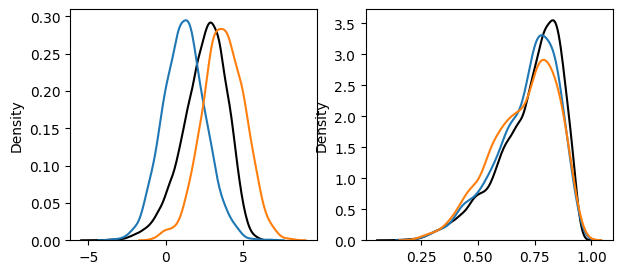

In [71]:
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors
from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def GetProp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return [[-100,-100],False]
    else:
        pvec = [Descriptors.MolLogP(mol),qed(mol),sascorer.calculateScore(mol)]
        return [pvec,True]

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molvae_param.pth.tar",map_location='cpu')
vae = MolVAE(36,128,480,3,0.2,DimZ,64,0.15)
vae.load_state_dict(chkpt['state_dict'])
vae.eval()

cvae = MolCVAE(36,128,480,3,0.2,DimZ,64,0.15)
chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molcvae_param.pth.tar",map_location='cpu')
cvae.load_state_dict(chkpt['state_dict'])

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.kdeplot(c_val[:,0],c='k',lw=1.5)
plt.subplot(1,3,2)
sns.kdeplot(c_val[:,1],c='k',lw=1.5)
plt.subplot(1,3,3)
sns.kdeplot(c_val[:,2],c='k',lw=1.5)

for k,c in enumerate([-1.0,1.0]):
    cond_vec = torch.Tensor(np.random.randn(2000,3))
    cond_vec[:,0] += c

    mols,z_mols,p_mols,val,uniq = Sampling_given_cond(cvae,DimZ,cond_vec,2000,120,tok_lib)

    c_samp = []
    for m in tqdm(mols):
        pv = GetProp(m)
        if pv[1]:
            c_samp.append(pv[0])

    c_samp = np.array(c_samp)

    plt.subplot(1,3,1)
    sns.kdeplot(c_samp[:,0])

    plt.subplot(1,3,2)
    sns.kdeplot(c_samp[:,1])

    plt.subplot(1,3,3)
    sns.kdeplot(c_samp[:,2])

QED sampling

100%|██████████| 1712/1712 [00:06<00:00, 253.29it/s]


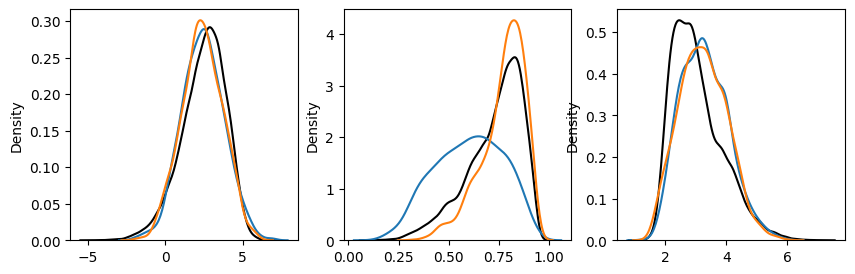

In [80]:
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors
from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def GetProp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return [[-100,-100],False]
    else:
        pvec = [Descriptors.MolLogP(mol),qed(mol),sascorer.calculateScore(mol)]
        return [pvec,True]

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molvae_param.pth.tar",map_location='cpu')
vae = MolVAE(36,128,480,3,0.2,DimZ,64,0.15)
vae.load_state_dict(chkpt['state_dict'])
vae.eval()

cvae = MolCVAE(36,128,480,3,0.2,DimZ,64,0.15)
chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molcvae_param.pth.tar",map_location='cpu')
cvae.load_state_dict(chkpt['state_dict'])

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.kdeplot(c_val[:,0],c='k',lw=1.5)
plt.subplot(1,3,2)
sns.kdeplot(c_val[:,1],c='k',lw=1.5)
plt.subplot(1,3,3)
sns.kdeplot(c_val[:,2],c='k',lw=1.5)

for k,c in enumerate([-2.0,1.0]):
    cond_vec = torch.Tensor(np.random.randn(2000,3))
    cond_vec[:,1] += c

    mols,z_mols,p_mols,val,uniq = Sampling_given_cond(cvae,DimZ,cond_vec,2000,120,tok_lib)

    c_samp = []
    for m in tqdm(mols):
        pv = GetProp(m)
        if pv[1]:
            c_samp.append(pv[0])

    c_samp = np.array(c_samp)

    plt.subplot(1,3,1)
    sns.kdeplot(c_samp[:,0])

    plt.subplot(1,3,2)
    sns.kdeplot(c_samp[:,1])

    plt.subplot(1,3,3)
    sns.kdeplot(c_samp[:,2])

SAscore sampling

100%|██████████| 1611/1611 [00:06<00:00, 245.37it/s]


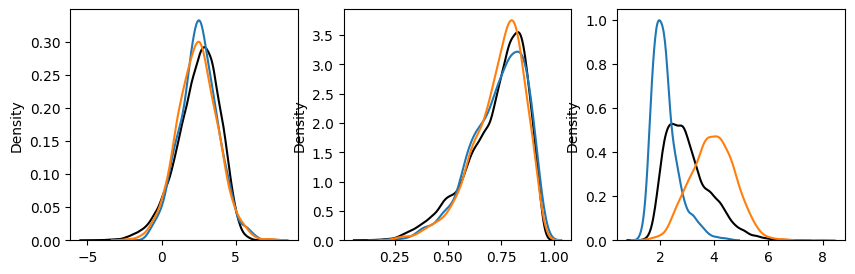

In [79]:
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors
from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def GetProp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return [[-100,-100],False]
    else:
        pvec = [Descriptors.MolLogP(mol),qed(mol),sascorer.calculateScore(mol)]
        return [pvec,True]

chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molvae_param.pth.tar",map_location='cpu')
vae = MolVAE(36,128,480,3,0.2,DimZ,64,0.15)
vae.load_state_dict(chkpt['state_dict'])
vae.eval()

cvae = MolCVAE(36,128,480,3,0.2,DimZ,64,0.15)
chkpt = torch.load("/content/drive/MyDrive/KRICT/UST수업/molcvae_param.pth.tar",map_location='cpu')
cvae.load_state_dict(chkpt['state_dict'])

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.kdeplot(c_val[:,0],c='k',lw=1.5)
plt.subplot(1,3,2)
sns.kdeplot(c_val[:,1],c='k',lw=1.5)
plt.subplot(1,3,3)
sns.kdeplot(c_val[:,2],c='k',lw=1.5)

for k,c in enumerate([-2.0,1.0]):
    cond_vec = torch.Tensor(np.random.randn(2000,3))
    cond_vec[:,2] += c

    mols,z_mols,p_mols,val,uniq = Sampling_given_cond(cvae,DimZ,cond_vec,2000,120,tok_lib)

    c_samp = []
    for m in tqdm(mols):
        pv = GetProp(m)
        if pv[1]:
            c_samp.append(pv[0])

    c_samp = np.array(c_samp)

    plt.subplot(1,3,1)
    sns.kdeplot(c_samp[:,0])

    plt.subplot(1,3,2)
    sns.kdeplot(c_samp[:,1])

    plt.subplot(1,3,3)
    sns.kdeplot(c_samp[:,2])

1712 1712
